# **Klasifikasi pada Iris dataset**


pada halaman ini, kita akan melakukan deteksi outlier menggunakan Local Outlier Factor, lalu melakukan preprocessing dengan memperbaiki data menggunakan regresi linear , dan melakukan klasifikasi menggunakan dua metode, yaitu klasifikasi K-NN dan Naive Bayes

In [ ]:
%pip install pymysql
%pip install psycopg2

In [ ]:

import pymysql
import psycopg2
import numpy as np
import pandas as pd

def get_mysql_data():
    conn = pymysql.connect(
        host="pendatviomysql-39-projectvioo.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_nnGCVuLriFaCit_hSPr",
        database="myiris",
        port=20305
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")  # Select all records from the table
    data = cursor.fetchall()  # Fetch all rows
    conn.close()
    # Convert to Python list
    data_list = [list(row) for row in data]
    # Convert to NumPy array
    data_numpy = np.array(data_list)
    return data_list

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-30810f3a-projectvioo.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_zzD9DhqapmhcWhqwe5C",
        database="defaultdb",
        port=20305
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_post")  # Select all records from the table
    data = cursor.fetchall()  # Fetch all rows
    cursor.close()
    conn.close()

    # Convert to Python list
    data_list = [list(row) for row in data]

    # Convert to NumPy array
    data_numpy = np.array(data_list)

    return data_list

columns = ['id', 'Class', 'sepal_length', 'sepal_width']
data_mysql = pd.DataFrame(get_mysql_data(), columns=columns)

columns = ['id', 'Class', 'petal_length', 'petal_width']
data_pg = pd.DataFrame(get_pg_data(), columns=columns)

df_merged = pd.merge(data_mysql, data_pg, on=["id", "Class"], how="inner")
print(df_merged.to_string(index=False))




 id           Class  sepal_length  sepal_width  petal_length  petal_width
  1     Iris-setosa           1.4          0.2           5.1          3.5
  2     Iris-setosa          14.0          2.0          40.9         30.0
  3     Iris-setosa           1.3          0.2           4.7          3.2
  4     Iris-setosa           1.5          0.2           4.6          3.1
  5     Iris-setosa           1.4          0.2           5.0          3.6
  6     Iris-setosa           1.7          0.4           5.4          3.9
  7     Iris-setosa           1.4          0.3           4.6          3.4
  8     Iris-setosa           1.5          0.2           5.0          3.4
  9     Iris-setosa           1.4          0.2           4.4          2.9
 10     Iris-setosa           1.5          0.1           4.9          3.1
 11     Iris-setosa           1.5          0.2           5.4          3.7
 12     Iris-setosa           1.6          0.2           4.8          3.4
 13     Iris-setosa           1.4     

## **Memasukkan 15 data Outlier**
kode di bawah ini berguna untuk secara sengaja membuat outlier sebanyak 15 agar dapat mendemonstrasikan proses deteksi outlier dan preprocessing

In [ ]:
import random
import pandas as pd

df = df_merged.copy(deep=True)
# Daftar ID dalam random_numbers
random_numbers = random.sample(df["id"].tolist(), 14)

# Ubah data untuk ID dalam random_numbers menjadi outlier
for idx in random_numbers:
    df.loc[df["id"] == idx, "sepal_length"] += random.uniform(1, 20)
    df.loc[df["id"] == idx, "sepal_width"] += random.uniform(1, 20)
    df.loc[df["id"] == idx, "petal_length"] += random.uniform(1, 20)
    df.loc[df["id"] == idx, "petal_width"] += random.uniform(1, 20)

# display(df)
print(df.to_string(index=False))



 id           Class  sepal_length  sepal_width  petal_length  petal_width
  1     Iris-setosa     19.681848    19.729505     14.866731    20.255201
  2     Iris-setosa     14.000000     2.000000     40.900000    30.000000
  3     Iris-setosa      1.300000     0.200000      4.700000     3.200000
  4     Iris-setosa      1.500000     0.200000      4.600000     3.100000
  5     Iris-setosa      1.400000     0.200000      5.000000     3.600000
  6     Iris-setosa      1.700000     0.400000      5.400000     3.900000
  7     Iris-setosa      1.400000     0.300000      4.600000     3.400000
  8     Iris-setosa      1.500000     0.200000      5.000000     3.400000
  9     Iris-setosa      1.400000     0.200000      4.400000     2.900000
 10     Iris-setosa      1.500000     0.100000      4.900000     3.100000
 11     Iris-setosa      1.500000     0.200000      5.400000     3.700000
 12     Iris-setosa      1.600000     0.200000      4.800000     3.400000
 13     Iris-setosa      1.400000     

Kode tersebut digunakan untuk menambahkan **outlier** secara acak sebanyak 15 pada dataset. Pertama, kode mengimpor modul `random` untuk memilih ID secara acak dari kolom "id" dalam dataset `df_merged`, serta menghasilkan nilai acak dalam rentang 1 hingga 20 menggunakan fungsi `random.uniform`.

 Dataset `df_merged` kemudian disalin menjadi `df` agar tidak memengaruhi data asli. Sebanyak 14 ID dipilih secara acak dengan `random.sample`, dan untuk setiap ID tersebut, nilai pada kolom fitur numerik seperti **sepal_length**, **sepal_width**, **petal_length**, dan **petal_width**

 ditambahkan dengan nilai acak. Proses ini menghasilkan nilai yang jauh menyimpang dari data normal, sehingga menciptakan outlier secara buatan dalam dataset. Terakhir, dataset yang telah dimodifikasi dicetak untuk memeriksa hasil perubahan. Tujuan kode ini biasanya adalah untuk menguji algoritma pendeteksi outlier atau mengevaluasi model dalam menangani data yang mengandung outlier.

## **Tahap Preprocessing**

### **Local Outlier Factor (LOF)**

Local Outlier Factor (**LOF**) adalah algoritma **deteksi outlier berbasis kepadatan (density-based)** yang membandingkan **kepadatan lokal** suatu titik dengan tetangganya. Jika suatu titik memiliki **kepadatan yang jauh lebih rendah dibandingkan tetangganya**, maka titik tersebut dianggap sebagai **outlier**.

 jika anda ingin mempelajari LOF lebih  lengkap, anda dapat melihat halaman sebelumnya.


### **Regresi Linear**
Regresi linear adalah metode statistik yang digunakan untuk menganalisis hubungan antara variabel independen (fitur) dan variabel dependen (target). Tujuan utama regresi linear adalah memodelkan hubungan linier tersebut dalam bentuk persamaan matematika. Persamaan dasar regresi linear adalah:
y = a + bx

dalam tahap preprocessing saya menggunakan regresi linear untuk memperbaiki data, saya memilih perbaikan data untuk menghindari ketidakseimbangan data antar class dan berkurangnya data setelah preprocessing, saya harap ini dapat meningkatkan akurasi dan menghasilkan plotting yang bagus karena jumlah data yang utuh

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor

# Dataframe awal dengan data kotor dan outlier
datab = df.copy(deep=True)
feature_columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

# Deteksi outlier menggunakan LOF
clf = LocalOutlierFactor(n_neighbors=20)
outlier_labels = clf.fit_predict(datab[feature_columns])
datab["outlier_label"] = outlier_labels

# Hitung jumlah data normal dan outlier
num_outliers = (datab["outlier_label"] == -1).sum()
num_normal = (datab["outlier_label"] == 1).sum()

# Pisahkan data menjadi normal dan outlier
df_normal = datab[datab["outlier_label"] == 1]
df_outlier = datab[datab["outlier_label"] == -1]

# Iterasi setiap kelas untuk memperbaiki outlier
classes = df_normal["Class"].unique()
for class_name in classes:
    # Filter data normal berdasarkan kelas
    class_data_normal = df_normal[df_normal["Class"] == class_name]

    # Dapatkan batas minimum dan maksimum untuk setiap fitur
    sepal_length_min = class_data_normal["sepal_length"].min()
    sepal_length_max = class_data_normal["sepal_length"].max()

    # Iterasi melalui data outlier pada kelas tersebut
    for idx, row in df_outlier[df_outlier["Class"] == class_name].iterrows():
        # Generate nilai random untuk sepal_length dalam batas normal
        random_sepal_length = np.random.uniform(sepal_length_min, sepal_length_max)

        # Gunakan regresi linear untuk memperbaiki fitur lainnya
        predictors = ["sepal_length"]  # Prediktor tunggal
        targets = ["sepal_width", "petal_length", "petal_width"]  # Target yang akan diprediksi

        for target in targets:
            # Latih regresi linear pada data normal
            model = LinearRegression()
            model.fit(class_data_normal[predictors], class_data_normal[target])

            # Prediksi nilai target berdasarkan nilai random
            predicted_value = model.predict(pd.DataFrame([[random_sepal_length]], columns=["sepal_length"]))

            # Perbarui nilai outlier
            datab.loc[idx, target] = predicted_value[0]

        # Ganti nilai random untuk sepal_length
        datab.loc[idx, "sepal_length"] = random_sepal_length


# Hapus kolom "outlier_label" setelah perbaikan
df_cleaned = datab.drop(columns=["outlier_label"])

# Hitung jumlah data setelah perbaikan
num_total = len(df_cleaned)

# Cetak hasil
print(f"Jumlah outlier yang terdeteksi: {num_outliers}")
print(f"Jumlah data normal: {num_normal}")
print(f"Jumlah total data setelah perbaikan: {num_total}")

# Dataframe hasil setelah perbaikan
print(df_cleaned.to_string(index=False))


Jumlah outlier yang terdeteksi: 21
Jumlah data normal: 129
Jumlah total data setelah perbaikan: 150
 id           Class  sepal_length  sepal_width  petal_length  petal_width
  1     Iris-setosa      1.592497     0.265153      5.046643     3.447112
  2     Iris-setosa      1.217711     0.184122      4.887100     3.310993
  3     Iris-setosa      1.300000     0.200000      4.700000     3.200000
  4     Iris-setosa      1.500000     0.200000      4.600000     3.100000
  5     Iris-setosa      1.400000     0.200000      5.000000     3.600000
  6     Iris-setosa      1.700000     0.400000      5.400000     3.900000
  7     Iris-setosa      1.400000     0.300000      4.600000     3.400000
  8     Iris-setosa      1.500000     0.200000      5.000000     3.400000
  9     Iris-setosa      1.400000     0.200000      4.400000     2.900000
 10     Iris-setosa      1.500000     0.100000      4.900000     3.100000
 11     Iris-setosa      1.500000     0.200000      5.400000     3.700000
 12     Iris

Kode di atas melakukan deteksi dan perbaikan outlier pada dataset menggunakan algoritma Local Outlier Factor (LOF) untuk mendeteksi outlier dan regresi linear untuk memperbaiki nilai yang terdeteksi sebagai outlier.

Pertama, dataset disalin ke dalam DataFrame baru, kegunaan nya agar kesalahan tidak mempengaruhi dataframe sebelumnya, lalu kolom fitur numerik utama seperti **sepal_length**, **sepal_width**, **petal_length**, dan **petal_width** digunakan sebagai input untuk model LOF. Algoritma LOF memberikan label -1 untuk data yang dianggap outlier dan 1 untuk data normal, yang kemudian disimpan dalam kolom tambahan bernama `outlier_label`. Setelah deteksi, data dibagi menjadi dua bagian: data normal (`df_normal`) dan data outlier (`df_outlier`).

Untuk setiap kelas dalam data normal, batas minimum dan maksimum fitur `sepal_length` dihitung, lalu kita generate nilai random antara batas minimum dan batas maximum. sebagai contoh, pada data normal class setosa memiliki batas minimum dan maksimum 1.4 sampai 1.7 dan kita mendapatkan nilai 1.5 setelah men generate nilai random

Nilai random ini digunakan sebagai prediktor dalam model regresi linear yang dilatih pada data normal untuk memprediksi nilai fitur lainnya, yaitu **sepal_width**, **petal_length**, dan **petal_width**, sehingga mengganti nilai outlier dengan hasil prediksi yang lebih realistis.
  
Setelah proses ini, outlier berhasil diperbaiki tanpa menghapus data apapun, menjaga integritas keseimbangan dataset . setelah preprocessing selesai dilakukan, kolom `outlier_label` dihapus, dan statistik seperti jumlah data normal, jumlah outlier, serta jumlah total data setelah perbaikan ditampilkan untuk memverifikasi proses yang telah dilakukan.

##**Klasifikasi K-Nearest Neighbors (K-NN)**

K-Nearest Neighbors (K-NN) adalah algoritma machine learning berbasis instance yang sangat sederhana namun efektif untuk tugas klasifikasi dan regresi.

Prinsip dasar K-NN adalah membandingkan kedekatan (jarak) suatu data baru dengan data yang sudah ada di dataset. Dengan kata lain, algoritma ini menggunakan informasi dari \(k\)-tetangga terdekat untuk memutuskan kelas atau nilai prediktor.

 Jika dalam tahap **data understanding**, K-NN sering digunakan untuk mendeteksi pola, menganalisis distribusi data, dan mendeteksi outlier.

  Dalam **modelling klasifikasi**, K-NN dapat digunakan untuk mengelompokkan data ke dalam kelas-kelas dengan melihat mayoritas label dari tetangga terdekat. Misalnya, untuk tugas klasifikasi tiga kelas (A, B, dan C), model K-NN akan menentukan kelas suatu data dengan menghitung jumlah tetangga dalam jarak tertentu yang berada dalam masing-masing kelas.

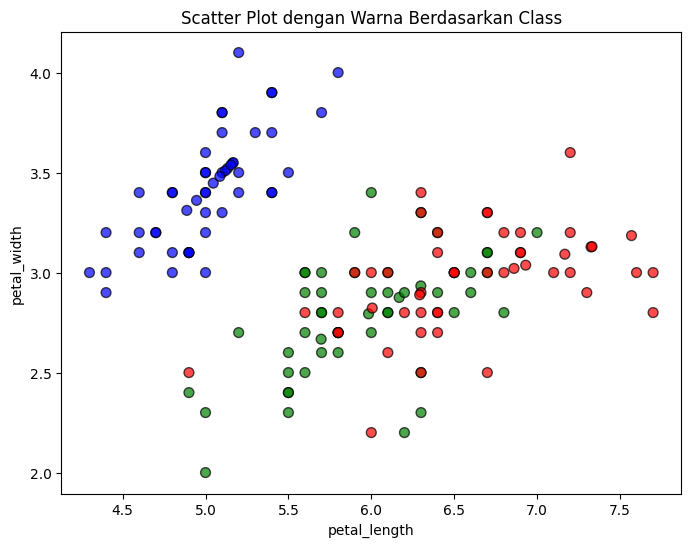

In [ ]:
import matplotlib.pyplot as plt

# Pilih dua fitur untuk scatter plot
x_feature = "petal_length"
y_feature = "petal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "green", "Iris-virginica": "red"}

df_cleaned["color"] = df_cleaned["Class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()

Kode ini membuat **scatter plot** untuk memvisualisasikan distribusi data dari dua fitur, yaitu **petal_length** dan **petal_width**, pada dataset `df_cleaned`. Warna titik pada plot ditentukan berdasarkan kelas (`Class`) dengan peta warna tertentu untuk setiap spesies (`Iris-setosa`, `Iris-versicolor`, `Iris-virginica`).

In [ ]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split


# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
X = df_merged[feature_columns].values  # Data fitur
y = df_merged["Class"]  # Label klasifikasi

# Bagi data menjadi Training (80%) dan Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned[feature_columns], df_cleaned["Class"], test_size=0.2, random_state=42
)

# Menampilkan jumlah data setelah pembagian
print(f"Jumlah data setelah preprocessing dengan mengkoreksi data: {df_cleaned.shape[0]}")
print(f"Training set: {X_train.shape[0]} sampel")
print(f"Testing set: {X_test.shape[0]} sampel")

# Visualisasi data setelah pembersihan
# sns.pairplot(df_cleaned, hue="class")
# plt.show()


Jumlah data setelah preprocessing dengan mengkoreksi data: 150
Training set: 120 sampel
Testing set: 30 sampel


Kode tersebut bertujuan untuk mendeteksi outlier dalam dataset menggunakan algoritma Local Outlier Factor (LOF) serta mempersiapkan data untuk klasifikasi dengan pembagian data latih dan uji.
 Pertama, modul Python seperti `psycopg2`, `pymysql`, `numpy`, `pandas`, `seaborn`, dan `matplotlib` diimpor untuk mengelola data, mendeteksi outlier, dan memvisualisasikan hasil. Dataset yang mengandung fitur numerik seperti **petal_length**, **petal_width**, **sepal_length**, dan **sepal_width** digunakan sebagai input untuk algoritma LOF, yang mengevaluasi kepadatan lokal setiap titik terhadap tetangganya dan menandai outlier dengan label -1. Kolom tambahan bernama `outlier` ditambahkan ke DataFrame untuk menyimpan hasil deteksi outlier. Setelah itu, data yang telah dibersihkan (tanpa outlier) dibagi menjadi data pelatihan (80%) dan data pengujian (20%) menggunakan fungsi `train_test_split`. Informasi mengenai jumlah data setelah preprocessing dan pembagiannya dicetak untuk verifikasi.



Data Tanpa Outlier
Akurasi: 85.19%
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.80      0.57      0.67         7
 Iris-virginica       0.70      0.88      0.78         8

       accuracy                           0.85        27
      macro avg       0.83      0.82      0.81        27
   weighted avg       0.86      0.85      0.85        27




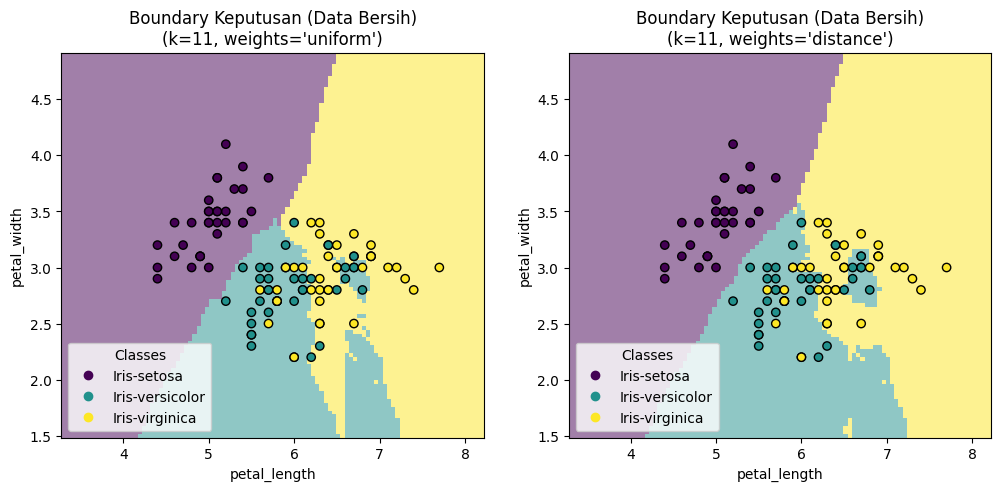


Data Dengan Outlier
Akurasi: 70.00%
                 precision    recall  f1-score   support

    Iris-setosa       0.89      0.80      0.84        10
Iris-versicolor       0.60      0.67      0.63         9
 Iris-virginica       0.64      0.64      0.64        11

       accuracy                           0.70        30
      macro avg       0.71      0.70      0.70        30
   weighted avg       0.71      0.70      0.70        30


Perbandingan Akurasi:
Akurasi data bersih: 85.19%
Akurasi data dengan outlier: 70.00%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Tentukan kolom fitur (gunakan 2 fitur untuk visualisasi boundary keputusan)
feature_columns = ["petal_length", "petal_width"]

# Encode label kelas menjadi nilai numerik
label_encoder = LabelEncoder()
y_encoded_cleaned = label_encoder.fit_transform(df_cleaned["Class"])
y_encoded_outlier = label_encoder.transform(df["Class"])

# Split data bersih (tanpa outlier)
X_cleaned = df_cleaned[feature_columns]
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, y_encoded_cleaned, test_size=0.2, random_state=42
)

# Split data dengan outlier
X_outlier = df[feature_columns]
X_train_outlier, X_test_outlier, y_train_outlier, y_test_outlier = train_test_split(
    X_outlier, y_encoded_outlier, test_size=0.2, random_state=42
)

# Inisialisasi pipeline dengan KNN
clf = Pipeline([
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# ----- Latih Model pada Data Bersih -----
clf.fit(X_train_cleaned, y_train_cleaned)
y_pred_cleaned = clf.predict(X_test_cleaned)
accuracy_cleaned = accuracy_score(y_test_cleaned, y_pred_cleaned)
cl_report_cleaned = classification_report(y_test_cleaned, y_pred_cleaned, target_names=label_encoder.classes_)

print("Data Tanpa Outlier")
print(f"Akurasi: {accuracy_cleaned * 100:.2f}%")
print(cl_report_cleaned)
print()

# Visualisasi boundary keputusan untuk data bersih
_, axs_cleaned = plt.subplots(ncols=2, figsize=(12, 5))
for ax, weights in zip(axs_cleaned, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train_cleaned, y_train_cleaned)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test_cleaned,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train_cleaned.iloc[:, 0], X_train_cleaned.iloc[:, 1],
        c=y_train_cleaned, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"Boundary Keputusan (Data Bersih)\n(k=11, weights={weights!r})"
    )
plt.show()

# ----- Latih Model pada Data dengan Outlier -----
clf.fit(X_train_outlier, y_train_outlier)
y_pred_outlier = clf.predict(X_test_outlier)
accuracy_outlier = accuracy_score(y_test_outlier, y_pred_outlier)
cl_report_outlier = classification_report(y_test_outlier, y_pred_outlier, target_names=label_encoder.classes_)
print("\nData Dengan Outlier")
print(f"Akurasi: {accuracy_outlier * 100:.2f}%")
print(cl_report_outlier)

#### jangan di nyalain anda akan kejang kejang melihatnya jika kode ini dinyalakan !!!!

# # Visualisasi boundary keputusan untuk data dengan outlier
# _, axs_outlier = plt.subplots(ncols=2, figsize=(12, 5))
# for ax, weights in zip(axs_outlier, ("uniform", "distance")):
#     clf.set_params(knn__weights=weights).fit(X_train_outlier, y_train_outlier)
#     disp = DecisionBoundaryDisplay.from_estimator(
#         clf,
#         X_test_outlier,
#         response_method="predict",
#         plot_method="pcolormesh",
#         xlabel=feature_columns[0],
#         ylabel=feature_columns[1],
#         shading="auto",
#         alpha=0.5,
#         ax=ax,
#     )
#     scatter = disp.ax_.scatter(
#         X_train_outlier.iloc[:, 0], X_train_outlier.iloc[:, 1],
#         c=y_train_outlier, edgecolors="k", cmap="viridis"
#     )
#     disp.ax_.legend(
#         scatter.legend_elements()[0],
#         label_encoder.classes_,
#         loc="lower left",
#         title="Classes",
#     )
#     _ = disp.ax_.set_title(
#         f"Boundary Keputusan (Data Dengan Outlier)\n(k=11, weights={weights!r})"
#     )
# plt.show()

# Perbandingan Akurasi
print("\nPerbandingan Akurasi:")
print(f"Akurasi data bersih: {accuracy_cleaned * 100:.2f}%")
print(f"Akurasi data dengan outlier: {accuracy_outlier * 100:.2f}%")


Kode di atas bertujuan untuk membandingkan performa model K-Nearest Neighbors (K-NN) pada dua dataset: data bersih tanpa outlier dan data yang mengandung outlier. Prosesnya dimulai dengan mengencode kelas menjadi nilai numerik menggunakan `LabelEncoder`, lalu dataset dibagi menjadi data pelatihan (80%) dan pengujian (20%) menggunakan dua fitur utama, yaitu **petal_length** dan **petal_width**.

 Model K-NN, dengan parameter \( k = 11 \), dilatih pada kedua dataset menggunakan pipeline untuk memastikan konsistensi dalam pengolahan data. Akurasi model dan laporan klasifikasi dihitung untuk masing-masing dataset, menunjukkan seberapa baik model dapat memisahkan kelas dalam kondisi bersih maupun dengan outlier.
 Selain itu, decision boundary divisualisasikan untuk dataset bersih dengan dua konfigurasi bobot K-NN (`uniform` dan `distance`) guna menunjukkan area klasifikasi setiap kelas dalam ruang fitur.

  Meskipun kode untuk visualisasi boundary pada data dengan outlier tersedia, bagian tersebut dinonaktifkan karena visualisasi data dengan outlier sering kali menyebabkan bug visual yang mengganggu
  akibat nilai outlier yang terlalu besar. Pada akhirnya, perbandingan akurasi antara kedua dataset dicetak untuk mengevaluasi dampak keberadaan outlier pada performa model.

  Setelah perbandingan akurasi di print, terlihat bahwa dataset yang bersih dari outlier memiliki akurasi yang jauh lebih tinggi

  berikut nya kita akan menggunakan kode yang sama untuk klasifikasi dengan sepal_length dan sepal_width

Data Tanpa Outlier
Akurasi: 100.00%
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      1.00      1.00         7
 Iris-virginica       1.00      1.00      1.00         8

       accuracy                           1.00        27
      macro avg       1.00      1.00      1.00        27
   weighted avg       1.00      1.00      1.00        27




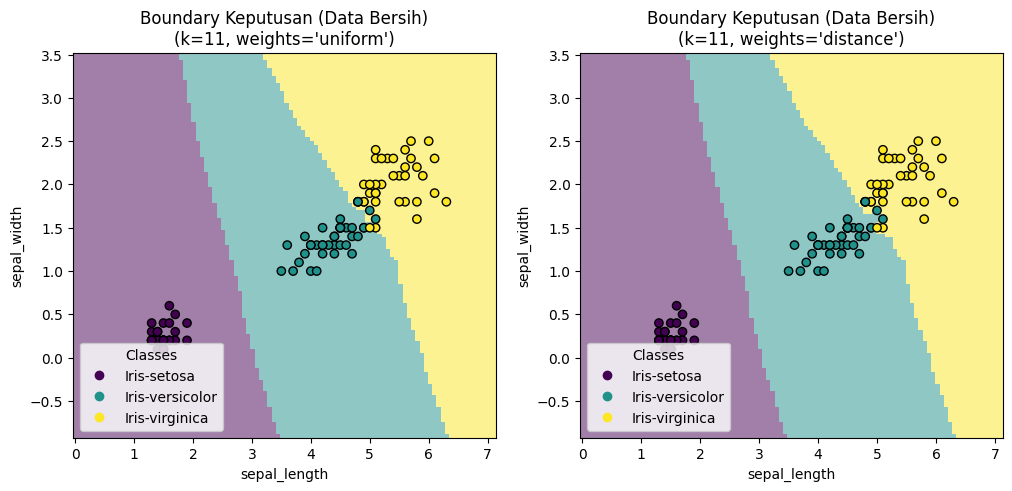


Data Dengan Outlier
Akurasi: 96.67%
                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.90      0.95        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       0.92      1.00      0.96        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30


Perbandingan Akurasi:
Akurasi data bersih: 100.00%
Akurasi data dengan outlier: 96.67%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Tentukan kolom fitur (gunakan 2 fitur untuk visualisasi boundary keputusan)
feature_columns = ["sepal_length", "sepal_width"]

# Encode label kelas menjadi nilai numerik
label_encoder = LabelEncoder()
y_encoded_cleaned = label_encoder.fit_transform(df_cleaned["Class"])
y_encoded_outlier = label_encoder.transform(df["Class"])

# Split data bersih (tanpa outlier)
X_cleaned = df_cleaned[feature_columns]
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, y_encoded_cleaned, test_size=0.2, random_state=42
)

# Split data dengan outlier
X_outlier = df[feature_columns]
X_train_outlier, X_test_outlier, y_train_outlier, y_test_outlier = train_test_split(
    X_outlier, y_encoded_outlier, test_size=0.2, random_state=42
)

# Inisialisasi pipeline dengan KNN
clf = Pipeline([
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# ----- Latih Model pada Data Bersih -----
clf.fit(X_train_cleaned, y_train_cleaned)
y_pred_cleaned = clf.predict(X_test_cleaned)
accuracy_cleaned = accuracy_score(y_test_cleaned, y_pred_cleaned)
cl_report_cleaned = classification_report(y_test_cleaned, y_pred_cleaned, target_names=label_encoder.classes_)

print("Data Tanpa Outlier")
print(f"Akurasi: {accuracy_cleaned * 100:.2f}%")
print(cl_report_cleaned)
print()

# Visualisasi boundary keputusan untuk data bersih
_, axs_cleaned = plt.subplots(ncols=2, figsize=(12, 5))
for ax, weights in zip(axs_cleaned, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train_cleaned, y_train_cleaned)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test_cleaned,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train_cleaned.iloc[:, 0], X_train_cleaned.iloc[:, 1],
        c=y_train_cleaned, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"Boundary Keputusan (Data Bersih)\n(k=11, weights={weights!r})"
    )
plt.show()

# ----- Latih Model pada Data dengan Outlier -----
clf.fit(X_train_outlier, y_train_outlier)
y_pred_outlier = clf.predict(X_test_outlier)
accuracy_outlier = accuracy_score(y_test_outlier, y_pred_outlier)
cl_report_outlier = classification_report(y_test_outlier, y_pred_outlier, target_names=label_encoder.classes_)
print("\nData Dengan Outlier")
print(f"Akurasi: {accuracy_outlier * 100:.2f}%")
print(cl_report_outlier)

#### jangan di nyalain anda akan kejang kejang melihatnya jika kode ini dinyalakan !!!!

# # Visualisasi boundary keputusan untuk data dengan outlier
# _, axs_outlier = plt.subplots(ncols=2, figsize=(12, 5))
# for ax, weights in zip(axs_outlier, ("uniform", "distance")):
#     clf.set_params(knn__weights=weights).fit(X_train_outlier, y_train_outlier)
#     disp = DecisionBoundaryDisplay.from_estimator(
#         clf,
#         X_test_outlier,
#         response_method="predict",
#         plot_method="pcolormesh",
#         xlabel=feature_columns[0],
#         ylabel=feature_columns[1],
#         shading="auto",
#         alpha=0.5,
#         ax=ax,
#     )
#     scatter = disp.ax_.scatter(
#         X_train_outlier.iloc[:, 0], X_train_outlier.iloc[:, 1],
#         c=y_train_outlier, edgecolors="k", cmap="viridis"
#     )
#     disp.ax_.legend(
#         scatter.legend_elements()[0],
#         label_encoder.classes_,
#         loc="lower left",
#         title="Classes",
#     )
#     _ = disp.ax_.set_title(
#         f"Boundary Keputusan (Data Dengan Outlier)\n(k=11, weights={weights!r})"
#     )
# plt.show()

# Perbandingan Akurasi
print("\nPerbandingan Akurasi:")
print(f"Akurasi data bersih: {accuracy_cleaned * 100:.2f}%")
print(f"Akurasi data dengan outlier: {accuracy_outlier * 100:.2f}%")


sama seperti kode sebelumnya namun kali ini kita menggunakan fitur sepal_length dan sepal_width


  Setelah perbandingan akurasi di print, terlihat bahwa dataset yang bersih dari outlier memiliki akurasi yang jauh lebih tinggi

  berikut nya kita lakukan klasifikasi K-NN dengan 4 fitur

In [ ]:
import pymysql
import psycopg2
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Ambil semua 4 fitur
feature_columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
X = df_merged[feature_columns]
y = df_merged["Class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Mengubah nama kelas menjadi angka

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Bersihkan data dengan menghapus outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["Class"]),  # Pastikan target dalam bentuk numerik
    test_size=0.2,
    random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
accuracy_cleaned = accuracy_score(y_test, y_pred)
print("Modelling K-NN dengan 4 fitur")
print("sepal_length, sepal_width,petal_length,petal_width,")
print(f"Akurasi data bersih: {accuracy_cleaned * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Modelling K-NN dengan 4 fitur
sepal_length, sepal_width,petal_length,petal_width,
Akurasi data bersih: 100.00%
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      1.00      1.00         7
 Iris-virginica       1.00      1.00      1.00         8

       accuracy                           1.00        27
      macro avg       1.00      1.00      1.00        27
   weighted avg       1.00      1.00      1.00        27



Kode ini digunakan untuk melakukan deteksi outlier, pembersihan dataset, dan klasifikasi menggunakan algoritma K-Nearest Neighbors (K-NN) dengan empat fitur.

 Pertama tama kita masukkan, empat fitur utama, yaitu **sepal_length**, **sepal_width**, **petal_length**, dan **petal_width**, dipilih sebagai data independen, sementara kolom **Class** digunakan sebagai label klasifikasi. Label kelas dikonversi ke bentuk numerik menggunakan `LabelEncoder`.


  Algoritma Local Outlier Factor (LOF) diterapkan untuk mendeteksi outlier dengan menggunakan 20 tetangga terdekat dan tingkat kontaminasi 10%, yang kemudian diberi label -1 (outlier) atau 1 (data normal).
  
  Data outlier di perbaiki dari dataset untuk menghasilkan data bersih (`df_cleaned`). Dataset bersih ini dibagi menjadi data pelatihan (80%) dan data pengujian (20%). Model pipeline kemudian diinisialisasi dengan komponen `StandardScaler` untuk menstandarkan data dan K-NN dengan \( k = 11 \) sebagai algoritma klasifikasi.
  
   Setelah pelatihan pada data bersih, model dievaluasi dengan menghitung akurasi dan laporan klasifikasi pada data pengujian. Akurasi hasil klasifikasi pada data bersih dicetak, menunjukkan performa model pada dataset yang telah dibersihkan dari outlier. Kode ini berfokus pada memastikan kualitas data dan penggunaan K-NN untuk memprediksi kelas secara optimal.

##**Klasifikasi Naive Bayes**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Dataset 'df' untuk data kotor dengan outlier
# Dataset 'df_cleaned' untuk data bersih tanpa outlier

# Fitur dan target pada data dengan outlier
X_outlier = df[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
y_outlier = df["Class"]

# Fitur dan target pada data bersih
X_cleaned = df_cleaned[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
y_cleaned = df_cleaned["Class"]

# Membagi data dengan outlier menjadi training (80%) dan testing (20%)
X_train_outlier, X_test_outlier, y_train_outlier, y_test_outlier = train_test_split(
    X_outlier, y_outlier, test_size=0.2, random_state=42
)

# Membagi data bersih menjadi training (80%) dan testing (20%)
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42
)

# Inisialisasi model Naive Bayes
nb_model = GaussianNB()

# ----- Klasifikasi pada Data dengan Outlier -----
nb_model.fit(X_train_outlier, y_train_outlier)
y_pred_outlier = nb_model.predict(X_test_outlier)
accuracy_outlier = accuracy_score(y_test_outlier, y_pred_outlier)

# Tambahkan kolom prediksi ke dataframe pengujian dengan outlier
df_test_outlier = X_test_outlier.copy()
df_test_outlier["Class"] = y_test_outlier.values
df_test_outlier["Predicted"] = y_pred_outlier
misclassified_outlier = df_test_outlier[df_test_outlier["Class"] != df_test_outlier["Predicted"]][["Class", "sepal_length", "sepal_width", "petal_length", "petal_width", "Predicted"]]

print("Data dengan Outlier")
print(f"Akurasi: {accuracy_outlier * 100:.2f}%")
print(f"Jumlah klasifikasi salah: {len(misclassified_outlier)}")
print("Data yang salah diklasifikasikan:")
print(misclassified_outlier)
print(classification_report(y_test_outlier, y_pred_outlier))
print()

# ----- Klasifikasi pada Data Bersih -----
nb_model.fit(X_train_cleaned, y_train_cleaned)
y_pred_cleaned = nb_model.predict(X_test_cleaned)
accuracy_cleaned = accuracy_score(y_test_cleaned, y_pred_cleaned)

# Tambahkan kolom prediksi ke dataframe pengujian bersih
df_test_cleaned = X_test_cleaned.copy()
df_test_cleaned["Class"] = y_test_cleaned.values
df_test_cleaned["Predicted"] = y_pred_cleaned
misclassified_cleaned = df_test_cleaned[df_test_cleaned["Class"] != df_test_cleaned["Predicted"]][["Class", "sepal_length", "sepal_width", "petal_length", "petal_width", "Predicted"]]

print("Data Bersih (Tanpa Outlier)")
print(f"Akurasi: {accuracy_cleaned * 100:.2f}%")
print(f"Jumlah klasifikasi salah: {len(misclassified_cleaned)}")
print("Data yang salah diklasifikasikan:")
print(misclassified_cleaned)
print(classification_report(y_test_cleaned, y_pred_cleaned))

# Perbandingan Akurasi dan Kesalahan
print("\nPerbandingan:")
print(f"Akurasi Data dengan Outlier: {accuracy_outlier * 100:.2f}%")
print(f"Jumlah klasifikasi salah pada Data dengan Outlier: {len(misclassified_outlier)}")
print(f"Akurasi Data Bersih: {accuracy_cleaned * 100:.2f}%")
print(f"Jumlah klasifikasi salah pada Data Bersih: {len(misclassified_cleaned)}")


Data dengan Outlier
Akurasi: 63.33%
Jumlah klasifikasi salah: 11
Data yang salah diklasifikasikan:
              Class  sepal_length  sepal_width  petal_length  petal_width  \
18      Iris-setosa      1.700000     0.300000      5.700000     3.800000   
31      Iris-setosa      1.500000     0.400000      5.400000     3.400000   
110  Iris-virginica      9.020808     5.410562     20.533845     7.971572   
12      Iris-setosa      1.400000     0.100000      4.800000     3.000000   
36      Iris-setosa      1.300000     0.200000      5.500000     3.500000   
9       Iris-setosa      1.500000     0.100000      4.900000     3.100000   
29      Iris-setosa      1.600000     0.200000      4.700000     3.200000   
127  Iris-virginica      4.900000     1.800000      6.100000     3.000000   
26      Iris-setosa      1.600000     0.400000      5.000000     3.400000   
45      Iris-setosa     11.622501     2.786071      9.964177    13.514046   
30      Iris-setosa      1.600000     0.200000      4.